# Forecasting Natural Gas Prices with Exogenous Variables

## Import Libraries

In [2]:
!pip install gluonts

     |████████████████████████████████| 569 kB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 11.8 MB/s eta 0:00:01     |█                               | 286 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 732 kB 64.7 MB/s eta 0:00:01
  Created wheel for holidays: filename=holidays-0.10.4-py3-none-any.whl size=124774 sha256=5d626ba4b3d3a0ae90bfdea14c1869ae00fb03734e5c8bd3814cfe94c720dc8b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/24/20/e0/beaaa13a665f8a4fa4bd61ad15293eb37ca88b187c7ae0e019
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=702876 sha256=c9292ab86427b52027cd25f82d8c79e6a354065e182beace9574649c9b5c5f1a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e9/c3/07/d32faf16682e2cd245be46e4c54053c8c82fa9762f4a4bcc63
Successfully built holidays pymeeus
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mx

In [44]:
from __future__ import print_function
%matplotlib inline
import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import datetime
import numpy as np
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas
from gluonts.mx.trainer import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.common import ListDataset, MetaData, TrainDatasets

In [4]:
# set random seeds for reproducibility
np.random.seed(33)
random.seed(33)

In [5]:
sagemaker_session = sagemaker.Session()

In [6]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'natural-gas-model-hyperparameter-tuning'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [7]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [8]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


## Load Data & Clean 

In [11]:
import pandas as pd
import numpy as np

price_full = pd.read_csv('naturalgasprices.csv')
weather = pd.read_csv(r'weather.csv', index_col=0, parse_dates=True)
storage = pd.read_csv(r'storage.csv', index_col=0, parse_dates=True)
spot = pd.read_csv(r'spot.csv', index_col=0, parse_dates=True)
futures = pd.read_csv(r'futures.csv', index_col=0, parse_dates=True)

In [12]:
price_full.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,12/4/2020,2.511,2.623,2.462,2.553,0.068,2.575,140379,297838
1,12/3/2020,2.760,2.768,2.484,2.512,-0.273,2.507,264650,298896
2,12/2/2020,2.881,2.934,2.740,2.756,-0.100,2.780,142057,297401
3,12/1/2020,2.934,2.972,2.833,2.876,-0.002,2.880,134920,297347
4,11/30/2020,2.831,2.996,2.823,2.934,0.039,2.882,136195,295779


In [13]:
price_full = price_full[['Date','Settle','Volume','Open','High','Low']]
price_full['Date'] = pd.to_datetime(price_full['Date'])

In [14]:
price_full = price_full.sort_index(ascending=False)
price_full.set_index('Date', inplace=True)

price_full.head()

,Settle,Volume,Open,High,Low
Date,,,,,
1990-04-03,1.635,240,1.580,1.655,1.580
1990-04-04,1.620,84,1.620,1.650,1.599
1990-04-05,1.615,57,1.615,1.635,1.610
1990-04-06,1.625,62,1.615,1.635,1.610
1990-04-09,1.637,37,1.612,1.640,1.612


In [15]:
#display(weather.head(), storage.head(), spot.head(), futures.head());

#display(spot.info(), weather.info(), storage.info(), futures.info());

In [16]:
merged = weather.merge(storage, how='outer', left_index=True, right_index=True)
merged_fill = merged.interpolate(method='linear', axis=0)

merged_fill.head(2)

,HDD,CDD,CONUS
Date,,,
2011-01-07,30,0,2960.000000
2011-01-08,33,0,2925.142857


In [19]:
full_fill = merged_fill.join(spot)
full_df = full_fill.interpolate(method='linear', axis=0)

full_df.head()

,HDD,CDD,CONUS,Spot
Date,,,,
2011-01-07,30,0,2960.000000,4.420000
2011-01-08,33,0,2925.142857,4.443333
2011-01-09,35,0,2890.285714,4.466667
2011-01-10,36,0,2855.428571,4.490000
2011-01-11,36,0,2820.571429,4.420000


##  Creating a Forecast Model

In [20]:
# specifying hyperparameters which will be consistent for all models
context_length = 28 # size of rolling window used to create forecast
prediction_length = 14 # size of forecast window
freq= 'D' # periodicity of forecast points

In [21]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

estimator = DeepAREstimator(freq=freq,
                            num_layers = 2,
                            num_cells = 32,
                            cell_type = 'lstm',
                            context_length=context_length,
                            prediction_length=prediction_length,
                            dropout_rate=0.2,
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=32))

### Creating In-Sample Forecast

In [22]:
train_ds = ListDataset([{FieldName.TARGET: full_df['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: full_df[['HDD','CDD','CONUS']][:-prediction_length].values.T,
                         FieldName.START: full_df.index[0]}],
                         freq=freq)

test_ds = ListDataset([{FieldName.TARGET: full_df['Spot'],
                         FieldName.FEAT_DYNAMIC_REAL: full_df[['HDD','CDD','CONUS']].values.T,
                         FieldName.START: full_df.index[0]}],
                         freq=freq)

In [45]:
datasets = TrainDatasets(
                        metadata=MetaData(
                                         freq=freq,
                                         target={'name': 'Spot'},
                                         prediction_length = prediction_length),
    
    train=train_ds,
    test=test_ds

)

## Exporting Data to Sagemaker 

In [46]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [47]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-2-689362889350/natural-gas-model-hyperparameter-tuning/data/train/train.json
Uploading file to s3://sagemaker-us-east-2-689362889350/natural-gas-model-hyperparameter-tuning/data/test/test.json
CPU times: user 41.3 ms, sys: 4.12 ms, total: 45.4 ms
Wall time: 226 ms


In [48]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"target":[4.4200000763,4.443333149,4.4666666985,4.4899997711,4.4200000763,4.5500001907,4.4800000191...


## Creating the Sagemaker Model 

In [53]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    base_job_name='natural-gas-model-tuner',
    output_path=s3_output_path
)

%%time

data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

## Defining the Static Hyperparameters 

In [56]:
static_hyperparameters = {
    'time_freq': freq,
    'epochs': 400,
    'early_stopping_patience': 40,
    'mini_batch_size': 64,
    'learning_rate': 5E-4,
    'context_length': str(context_length),
    'prediction_length': str(prediction_length)
}

estimator.set_hyperparameters(**static_hyperparameters)

## Establishing Dynamic Hyperparameter Tuning Ranges 

In [55]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

In [57]:
tuned_hyperparameter_ranges = {
    'num_cells' : IntegerParameter(30, 200),
    'num_layers' : IntegerParameter(1, 4),
    'dropout_rate' : ContinuousParameter(0.0, 0.9),
    'embedding_dimension' : IntegerParameter(10, 100),
    'learning_rate' : ContinuousParameter(1e-5, 0.1)
}

In [63]:
%%time
import uuid

tuner = HyperparameterTuner(estimator,
                            objective_metric_name='test:RMSE',
                            objective_type='Minimize',
                            hyperparameter_ranges=tuned_hyperparameter_ranges,
                            max_jobs=50,
                            max_parallel_jobs=4)

tuner.fit(inputs=data_channels, job_name='tune-model-ng-'+str(uuid.uuid4())[:5],
          include_cls_metadata=False)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [403]:
predictor = estimator.train(train_ds)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.04it/s, epoch=32/32, avg_epoch_loss=-.18]


In [404]:
forecast_it, ts_it = make_evaluation_predictions(
                                                dataset=test_ds,  # test dataset
                                                predictor=predictor,  # predictor
                                                num_samples=100)  # number of sample paths we want for evaluation

In [405]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [406]:
# first entry of the time series list
ts_entry = tss[0]

In [413]:
test_ds_entry = next(iter(test_ds))

In [407]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [408]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 14)
Start date of the forecast window: 2020-12-12 00:00:00
Frequency of the time series: D


In [365]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 56
    
    prediction_intervals = (50.0, 90.0)
    legend = ['observed price', 'median prediction'] + [f'{k}% prediction interval' for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax, color='black')  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='dodgerblue')
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show()

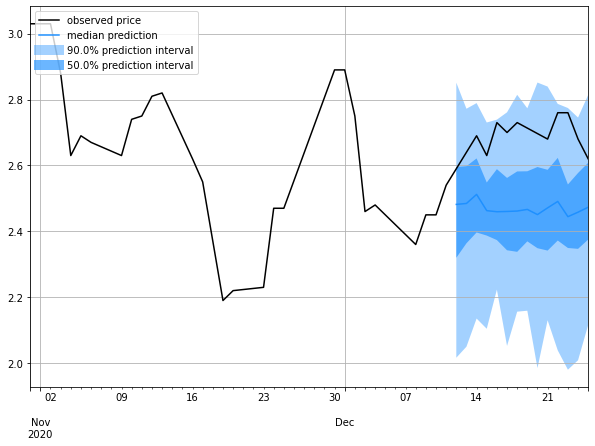

In [366]:
plot_prob_forecasts(ts_entry, forecast_entry)

### Creating a Future Forecast 

In [370]:
from current_weather_grabber import *

In [371]:
scrape_weather()

In [372]:
current_weather = pd.read_csv(r'current_weather.csv', index_col=0, parse_dates=True)

future_forecast = full_df.append(current_weather)

In [373]:
future_forecast.at['2021-01-01', 'CONUS'] = 3139
future_forecast.at['2021-01-08', 'CONUS'] = 2978
future_forecast.drop(['Temp','Base_Temp','Year'], axis=1, inplace=True)
future_forecast['CONUS'] = future_forecast['CONUS'].interpolate()

In [374]:
future_forecast.tail(16)

,HDD,CDD,CONUS,Spot
2020-12-24,25.00,0.00,3476.285714,2.68
2020-12-25,28.00,0.00,3460.000000,2.62
2020-12-26,21.81,0.58,3414.142857,NaN
2020-12-27,21.83,0.53,3368.285714,NaN
2020-12-28,21.80,0.24,3322.428571,NaN
2020-12-29,22.67,0.05,3276.571429,NaN
2020-12-30,21.53,0.06,3230.714286,NaN
2020-12-31,17.74,0.38,3184.857143,NaN
2021-01-01,22.96,0.66,3139.000000,NaN
2021-01-02,24.02,0.50,3116.000000,NaN


In [375]:
forecast_train = ListDataset([{FieldName.TARGET: future_forecast['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: future_forecast[['HDD','CDD','CONUS']][:-prediction_length].values.T,
                         FieldName.START: future_forecast.index[0]}],
                         freq=freq)

forecast_test = ListDataset([{FieldName.TARGET: future_forecast['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: future_forecast[['HDD','CDD','CONUS']].values.T,
                         FieldName.START: future_forecast.index[0]}],
                         freq=freq)

In [376]:
pred_future = estimator.train(forecast_train)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|███████████████████████████████████████████████| 50/50 [00:03<00:00, 14.80it/s, epoch=32/32, avg_epoch_loss=-.162]


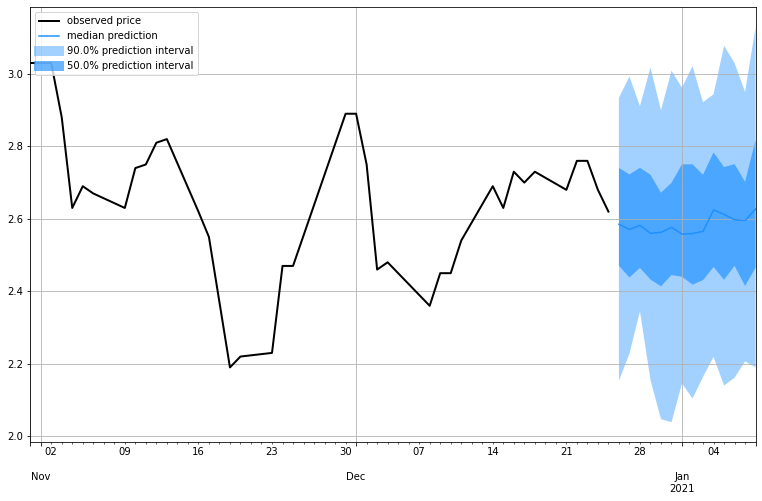

In [377]:
for test_entry, forecast in zip(forecast_test, pred_future.predict(forecast_test)):
    to_pandas(test_entry)[-56:].plot(linewidth=2, color='black')
    forecast.plot(color='dodgerblue', prediction_intervals=[50.0, 90.0])
    prediction_intervals = (50.0, 90.0)
    legend = ['observed price', 'median prediction'] + [f'{k}% prediction interval' for k in prediction_intervals][::-1]
    plt.grid(which='major')
    plt.legend(legend, loc='upper left')